# Clustering Yelp Restaurants

**Part 2: To be completed INDIVIDUALLY and due on October 20 at 5pm.**

In this assignment, we will continue to work with the [Yelp dataset](https://www.yelp.com/dataset/challenge) that we used in Homework 2-1. Download the data from Round 10. You can find the format of the dataset [here](https://www.yelp.com/dataset/documentation/json).

We will continue to try to find culinary districts in Las Vegas. 

(As a reminder from last time, these are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness.)

However, in this analysis we will not use the Yelp-supplied "categories" to cluster for similarity as we did in Part 1.

Instead we will cluster the reviews themselves, extracting categories in an unsupervised fashion.  

Specifically, you are to use Latent Semantic Analysis (LSA) on the Yelp reviews to cluster restaurants based off on their reviews.  As a reminder, LSA consists of using PCA applied to the document-term matrix.

LSA was covered in lecture, and there is another tutorial [here.](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
)

**(20 pts)**

In [28]:
import json
import pandas as pd
from pandas import DataFrame
from collections import defaultdict
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import matplotlib.cm
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances as pairdist
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

In [2]:
# Getting top Categories to cluster for Similarity
cat_no=[]
restaurant = []

file_open = open('business.json')
for i in file_open:
    cat = json.loads(i)
    if 'Restaurants' in cat['categories']:
        if cat['city'] =='Las Vegas':
            restaurant.append({'business_id':cat['business_id'],'longitude':cat['longitude'],'latitude':cat['latitude']})
            for j in cat['categories']:
                cat_no.append(j)

restaurant_df=DataFrame(restaurant)

latitudes = restaurant_df['latitude'].tolist()
longitudes = restaurant_df['longitude'].tolist()
latitudes = np.asarray(latitudes)
longitudes = np.asarray(longitudes)

restaurant_df.head(50)

,business_id,latitude,longitude
0,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799
1,QTH_XGh4rWYdd0fTW-tUDw,36.112519,-115.242605
2,DiA78qPtp6rfRNdomzjBbw,36.083384,-115.033995
3,YTqtM2WFhcMZGeAGA08Cfg,36.159363,-115.135949
4,Oto60yDwk1z72WmfWEYrjg,36.012191,-115.173993
5,mUk-0jToBuzk4KaDXp-uew,36.016580,-115.118701
6,1CP8aJa8ILlfM5deroar0Q,36.100251,-115.209894
7,TYGVaav4hWZioQlk9Ig78A,36.151098,-115.159804
8,Wbi-x-1Nbn6LFCMOSN6F5Q,36.279467,-115.208013
9,W-3Sy3fy85mQdd0ZNFKIiw,36.125270,-115.243588


In [3]:
# Getting reviews of businesses
reviews=[]
file_open = open('review.json',encoding="utf8")
for i in file_open:
    cat = json.loads(i)
    reviews.append({'business_id':cat['business_id'],'review':cat['text']})
    
reviews_df=DataFrame(reviews)

In [4]:
rev_t =pd.merge(reviews_df,restaurant_df)

rev_all=[]
for i in rev_t.groupby('business_id')['review']:
    r=''
    for j in i[1]:
        r+=j
    rev_all.append({'business_id':i[0],'review':str(r)})
total_reviews = DataFrame(rev_all)    
mat_df=pd.merge(restaurant_df,total_reviews)

In [6]:
reviews_list = mat_df['review'].tolist()
mat_df.head(5)

,business_id,latitude,longitude,review
0,LDMCrFlGIFUN6L-FEFgzWg,36.196203,-115.116799,I've been eating chicken at el poll loco since...
1,QTH_XGh4rWYdd0fTW-tUDw,36.112519,-115.242605,The last two times I've been to this place the...
2,DiA78qPtp6rfRNdomzjBbw,36.083384,-115.033995,Love that this store is in my neighborhood. It...
3,YTqtM2WFhcMZGeAGA08Cfg,36.159363,-115.135949,Great place. There was a man here who was very...
4,Oto60yDwk1z72WmfWEYrjg,36.012191,-115.173993,Below mediocre. Our expectations were not very...


In [7]:
from string import digits
remove_digits = str.maketrans('', '', digits)
reviews_list = [rev.translate(remove_digits) for rev in reviews_list]

In [8]:
vectorizer = TfidfVectorizer(decode_error='ignore', ngram_range=(1,1), stop_words='english', max_df=0.8, min_df=0.3)
dtm = vectorizer.fit_transform(reviews_list)
terms = vectorizer.get_feature_names()

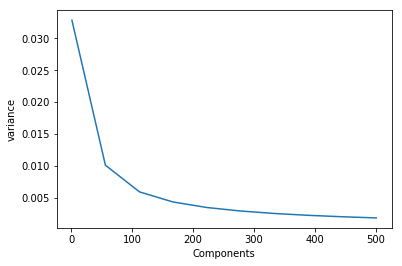

In [9]:
variance = np.zeros(10)
i = 0
for k in np.linspace(1,501, 10, dtype='int16'):
    lsa = TruncatedSVD(k, algorithm = 'arpack')
    lsa_t = lsa.fit(dtm)
    variance[i] = lsa_t.explained_variance_ratio_.mean()
    i += 1
    
plt.plot(np.linspace(1,501, 10, dtype='int16'),variance)
plt.xlabel('Components')
dummy = plt.ylabel('variance')
plt.show()

In [10]:
lsa = TruncatedSVD(60, algorithm = 'randomized')
lsa_t = lsa.fit_transform(dtm)
# normalize category columns and rescale to give location a larger weight
lsa_t = Normalizer(copy=False).fit_transform(lsa_t)

In [9]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

# stemming
from nltk.tokenize import sent_tokenize
reviews_list = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(rev)
        for word in word_tokenize(sent))
        for rev in reviews_list]

In [11]:
X = np.linspace(1,501, 10, dtype='int16')
lsa = TruncatedSVD(n_components=2, algorithm = 'randomized')
dtm1 = dtm.asfptype()
dtm_lsa = lsa.fit_transform(dtm1)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
lsa.singular_values_

array([ 39.91055628,  18.45213492])

In [41]:
pd.DataFrame(dtm_lsa, index = reviews_df.review.values, columns = ["component_1","component_2"])

,component_1,component_2
"My girlfriend and I stayed here for 3 nights and loved it. The location of this hotel and very decent price makes this an amazing deal. When you walk out the front door Scott Monument and Princes street are right in front of you, Edinburgh Castle and the Royal Mile is a 2 minute walk via a close right around the corner, and there are so many hidden gems nearby including Calton Hill and the newly opened Arches that made this location incredible.\n\nThe hotel itself was also very nice with a reasonably priced bar, very considerate staff, and small but comfortable rooms with excellent bathrooms and showers. Only two minor complaints are no telephones in room for room service (not a huge deal for us) and no AC in the room, but they have huge windows which can be fully opened. The staff were incredible though, letting us borrow umbrellas for the rain, giving us maps and directions, and also when we had lost our only UK adapter for charging our phones gave us a very fancy one for free.\n\nI would highly recommend this hotel to friends, and when I return to Edinburgh (which I most definitely will) I will be staying here without any hesitation.",0.853401,0.521255
"If you need an inexpensive place to stay for a night or two then you may consider this place but for a longer stay I'd recommend somewhere with better amenities. \n\nPros:\nGreat location- you're right by the train station, central location to get to old town and new town, and right by sight seeing his tours. Food, bars, and shopping all within walking distance. Location, location, location.\nVery clean and very good maid service\n\nCons:\nTiny rooms \nUncomfortable bed \nAbsolutely no amenities \nNo phone in room \nNo wardrobe \n\nWas given a lot of attitude about me and my husband sharing a room which was quite strange and we were charged 15 pounds more for double occupancy not sure why that matters I felt like it was a money grab. It was just handled in a kind of odd manner to me... \n\nIf you book this hotel all you get is a bed, desk, and a bathroom. It isn't awful but know what you're getting into.",0.990722,-0.135900
"Mittlerweile gibt es in Edinburgh zwei Ableger der Motel-One-Kette - diese hier ist eher das schlechtere.\n\nWir hatten auf unserer Schottlandtour die Gelegenheit beide Ableger kennenzulernen, da wir beide Nächte in Edinburgh (am ersten sowie am letzten Tag) in einem der beiden Motel One's verbrachten. Von diesem hier waren wir nach dem überraschend positiven Erlebnis im Motel One an der Princes Street [1] etwas enttäuscht.\n\nDas Hotel ist wesentlich größer und extrem unübersichtlich. Da man auf der fünften Etage noch Teile eines weiteren Gebäude, das mittels einer Glasbrücke mit dem Hauptgebäude verbunden ist, hinzugenommen hat, kann die Suche nach dem Zimmer insbesondere auf dieser Etage zu einem Gang im Labyrinth ausarten. Habe ich so noch in keinem Hotel erlebt - uns begegneten immer wieder Menschen, die sich auf der Suche nach ihren Zimmern verirrt haben.\nUnser Zimmer war ähnlich aufgebaut wie das Zimmer im Motel One Princes Street - befand sich jedoch im Inneren des Gebäudes und hatte daher kein Fenster. Nur eine kleine Dachluke, die sich am oberen Ende eines etwa 3m langen Schachts befand, sorgte für einen minimalen Anteil Tageslicht im Zimmer. diese Luke ließ sich auch nicht öffnen, nur ein elektrisches Rollo ließ sich mittels eines Schalters öffnen bzw. schließen.\nSonst gilt für das Zimmer eigentlich das Gleiche wie für das Zimmer im im Motel One Princes Street: Relativ klein, trotzdem extrem ansprechend und schick gestaltet und clever durchdacht. Dazu sehr ruhig.\n\nIm gesamten Hotel gibt es kostenloses WLAN für die Dauer des Aufenthalts für maximal 3 Geräte.\n\nDie Lage des Motel One Royal Mile ist großartig. Vom Airlink-Flughafenbus kann man quasi in den Hoteleingang stolpern, es sind maximal 50m. Zur Royal Mile sind es etwa 100m Luftlinie (bergauf) und man benötigt etwa 5 Minuten bis dort.\n\nDas Frühstück für 9,

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot and label each cluster. 

Note that to label each cluster, you will need to think about how to extract labels from the LSA results.
**(25 pts)**

In [12]:
centered_location = Normalizer(copy=False).fit_transform(np.column_stack((latitudes, longitudes)))
dtm_final = np.concatenate((lsa_t, centered_location), axis=1)

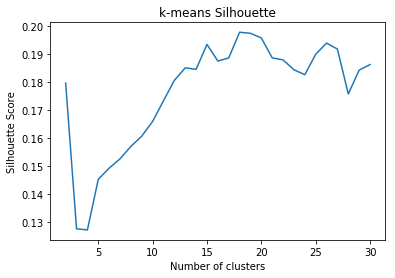

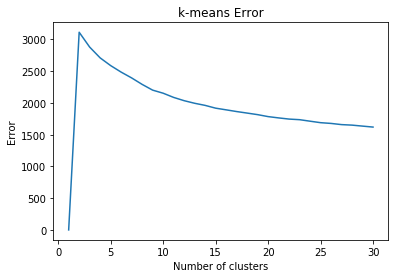

In [13]:
mat = lsa_t
max_clusters = 30
s_k = np.zeros(max_clusters+1)
error = np.zeros(max_clusters+1)
error[0] = 0;
s_k[0] = 0;
s_k[1] = 0;
for k in range(2,max_clusters+1):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    result = kmeans.fit_predict(dtm_final)
    s_k[k] = silhouette_score(dtm_final,kmeans.labels_,metric='euclidean')
    error[k] = kmeans.inertia_
plt.plot(range(2,len(s_k)),s_k[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('k-means Silhouette')
plt.show()
plt.title('k-means Error')
plt.plot(range(1,len(error)),error[1:])
plt.xlabel('Number of clusters')
dummy = plt.ylabel('Error')
plt.show()

In [14]:
mat = dtm_final

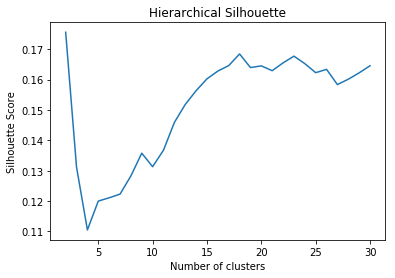

In [15]:
max_clusters = 30
s_k1 = np.zeros(max_clusters+1)
s_k1[0] = 0;
s_k1[1] = 0;
for k in range(2,max_clusters+1):
    hier = AgglomerativeClustering(n_clusters=k)
    result_1 = hier.fit_predict(mat)
    s_k1[k] = silhouette_score(mat,hier.labels_,metric='euclidean')
plt.plot(range(2,len(s_k1)),s_k1[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Hierarchical Silhouette')
plt.show()

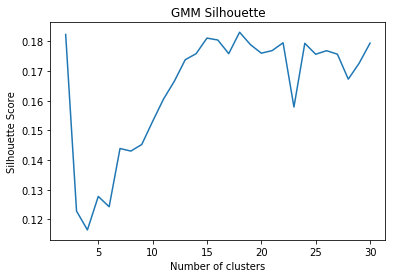

In [17]:
import warnings
warnings.filterwarnings('ignore')
max_clusters = 30
s_k2 = np.zeros(max_clusters+1)
s_k2[0] = 0;
s_k2[1] = 0;
for k in range(2,max_clusters+1):
    Gmm = mixture.GMM(n_components=k, covariance_type='spherical')
    result_2 = Gmm.fit_predict(mat)
    s_k2[k] = silhouette_score(mat,result_2)
plt.plot(range(2,len(s_k2)),s_k2[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('GMM Silhouette')
plt.show()

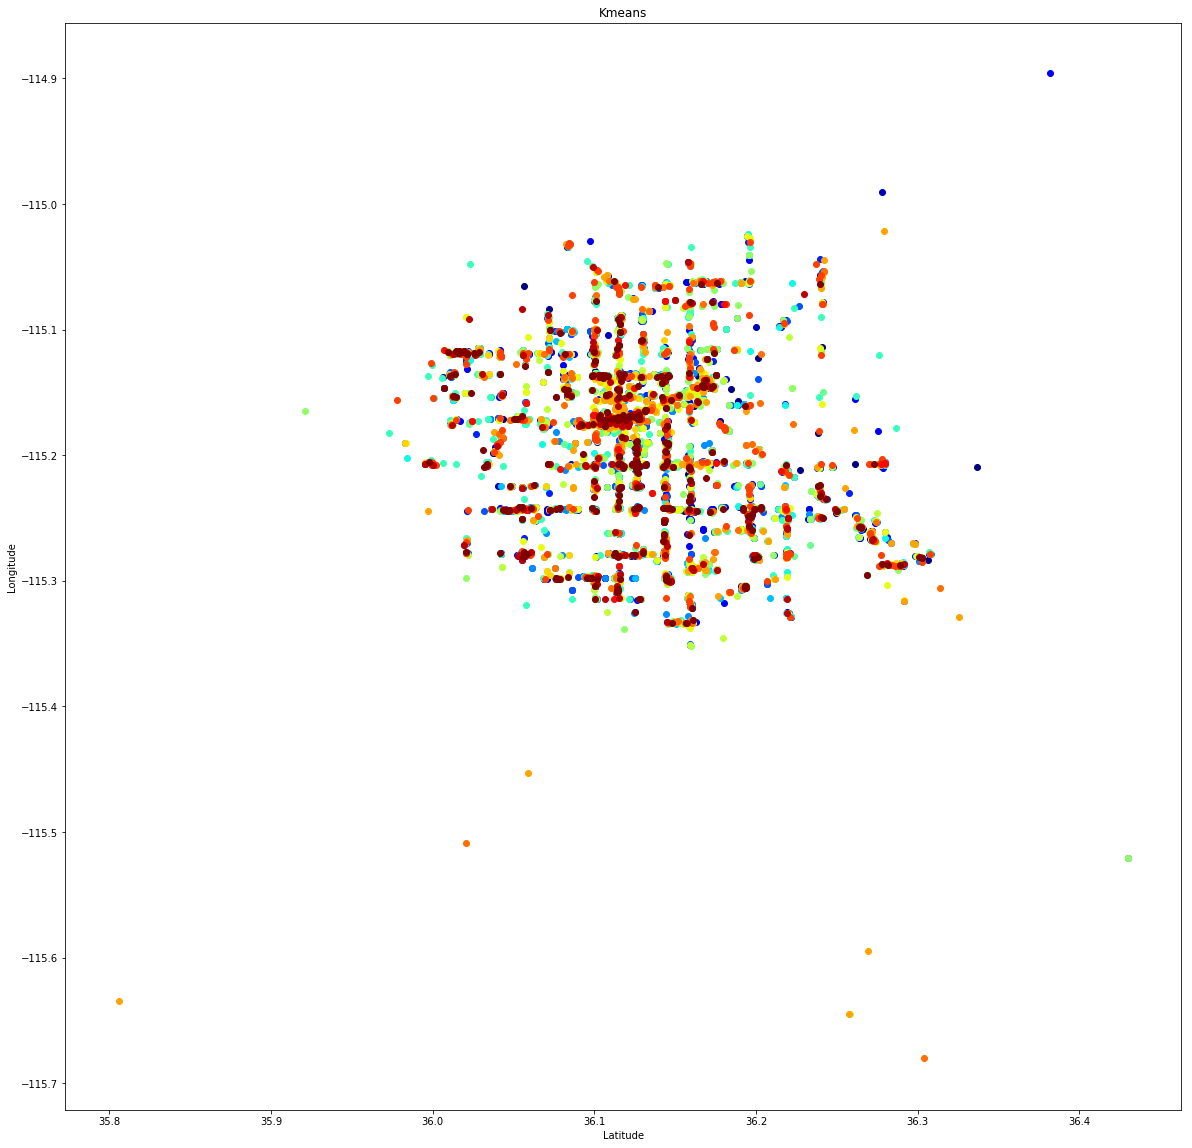

In [125]:
#Using the Silhouete Score 20 clusters is the best choice for clustering
import warnings
warnings.filterwarnings('ignore')
K = 20
kmeans = KMeans(init='k-means++', n_clusters=K, max_iter=300)
result = kmeans.fit_predict(mat)
lab = kmeans.labels_
asc_centroids=kmeans.cluster_centers_[:,-K:].argsort()[:,::-1]
figure_plt =plt.figure(figsize=(20,20))
colors = matplotlib.cm.jet(np.linspace(0, 1, K))
inertia_k =kmeans.inertia_
s_k = silhouette_score(mat,result)
for k in range(K):
    plt.scatter(latitudes[result==k],longitudes[result==k],c=colors[k,:]) 
 
plt.title('Kmeans')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [105]:

for i in range(20):
        print("Cluster %d:" % i)
        for j in asc_centroids[i,:10]:
            print(terms[j+1])
        print("______________")

Cluster 0:
american
addition
admit
accommodating
alright
ago
amazing
agree
affordable
afternoon
______________
Cluster 1:
american
add
addition
ahead
agree
alright
accommodating
absolute
added
actually
______________
Cluster 2:
american
ahead
absolute
actually
added
actual
alright
ago
add
agree
______________
Cluster 3:
american
absolute
admit
absolutely
added
amazing
affordable
ahead
afternoon
actually
______________
Cluster 4:
american
absolutely
afternoon
ambiance
added
amazing
affordable
accommodating
alright
ago
______________
Cluster 5:
american
accommodating
absolutely
agree
absolute
ambiance
alright
ago
additional
afternoon
______________
Cluster 6:
american
add
affordable
actually
actual
added
absolute
ahead
alright
ambiance
______________
Cluster 7:
american
agree
absolutely
affordable
accommodating
addition
ambiance
additional
actually
absolute
______________
Cluster 8:
american
afternoon
alright
ahead
actually
ambiance
add
addition
additional
added
______________
Cluster 9:

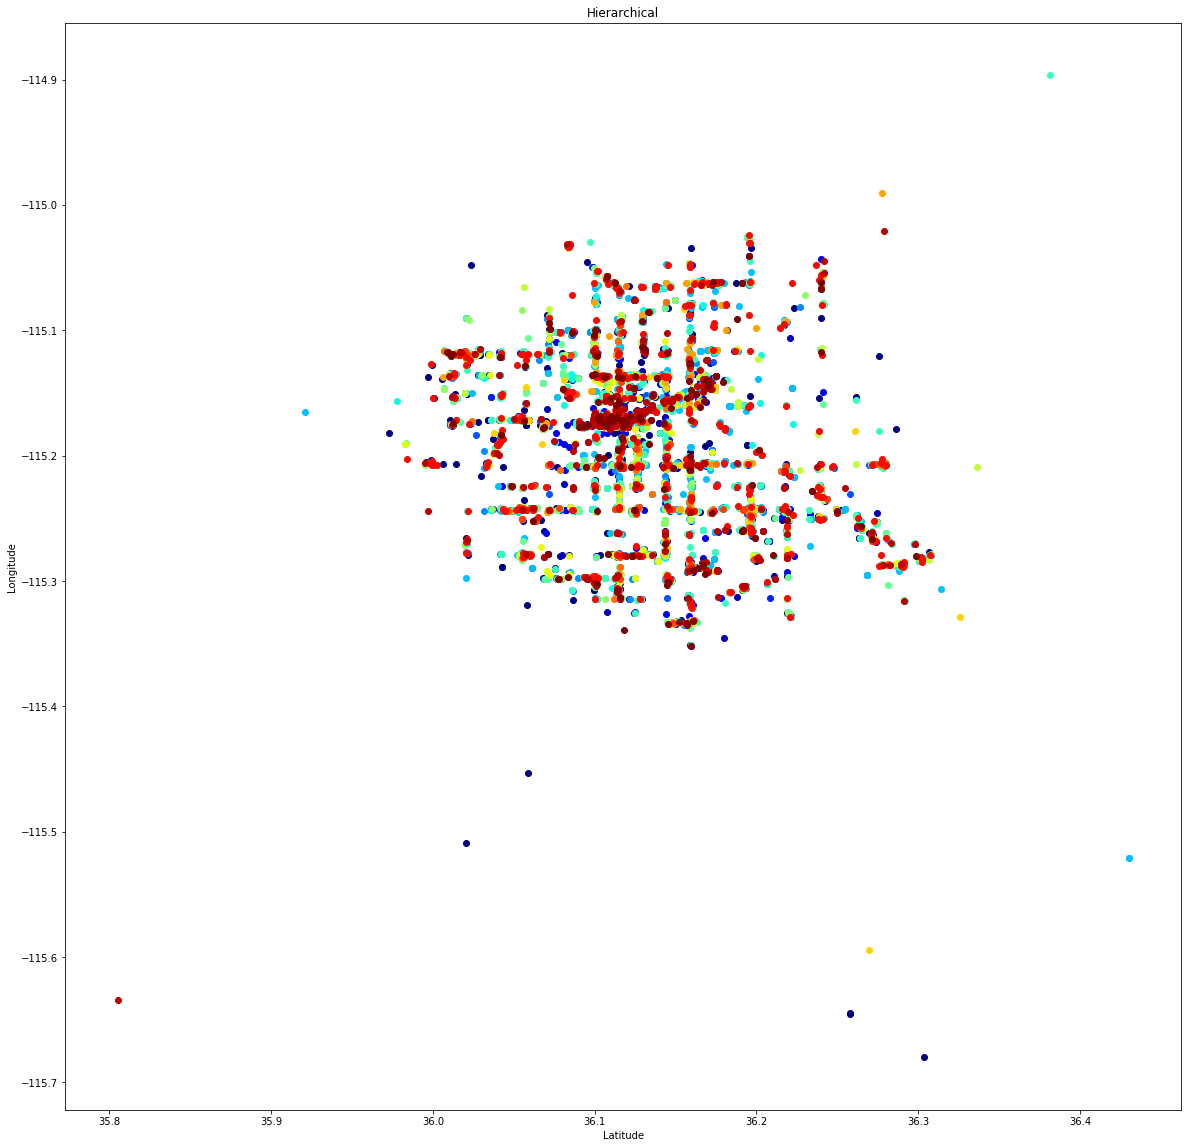

In [127]:
#Using the Silhouete Score 20 clusters is the best choice for clustering
import warnings
warnings.filterwarnings('ignore')
K = 20

hier = AgglomerativeClustering(n_clusters=K, linkage ='ward')

result_1 = hier.fit_predict(mat)
figure_plt =plt.figure(figsize=(20,20))
colors = matplotlib.cm.jet(np.linspace(0, 1, K))
inertia_h = 0
s_h = silhouette_score(mat,result_1)

for k in range(K):
    kmean_h=KMeans(init='k-means++',n_clusters=1,max_iter=300)
    label = kmean_h.fit_predict(mat[result_1==k])
    inertia_h +=kmean_h.inertia_
    plt.scatter(latitudes[result_1==k],longitudes[result_1==k],c=colors[k,:])
 
plt.title('Hierarchical')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [ ]:
center_agg = lsa.inverse_transform(np.mean(mat[agg_labels==1][:,:100], axis=0)).argsort()[::-1].r
for i in range(K):
        print("Cluster %d:" % i)
        for ind in agg_labels[i,:5]:
            print(terms[ind+1])
        print("______________")

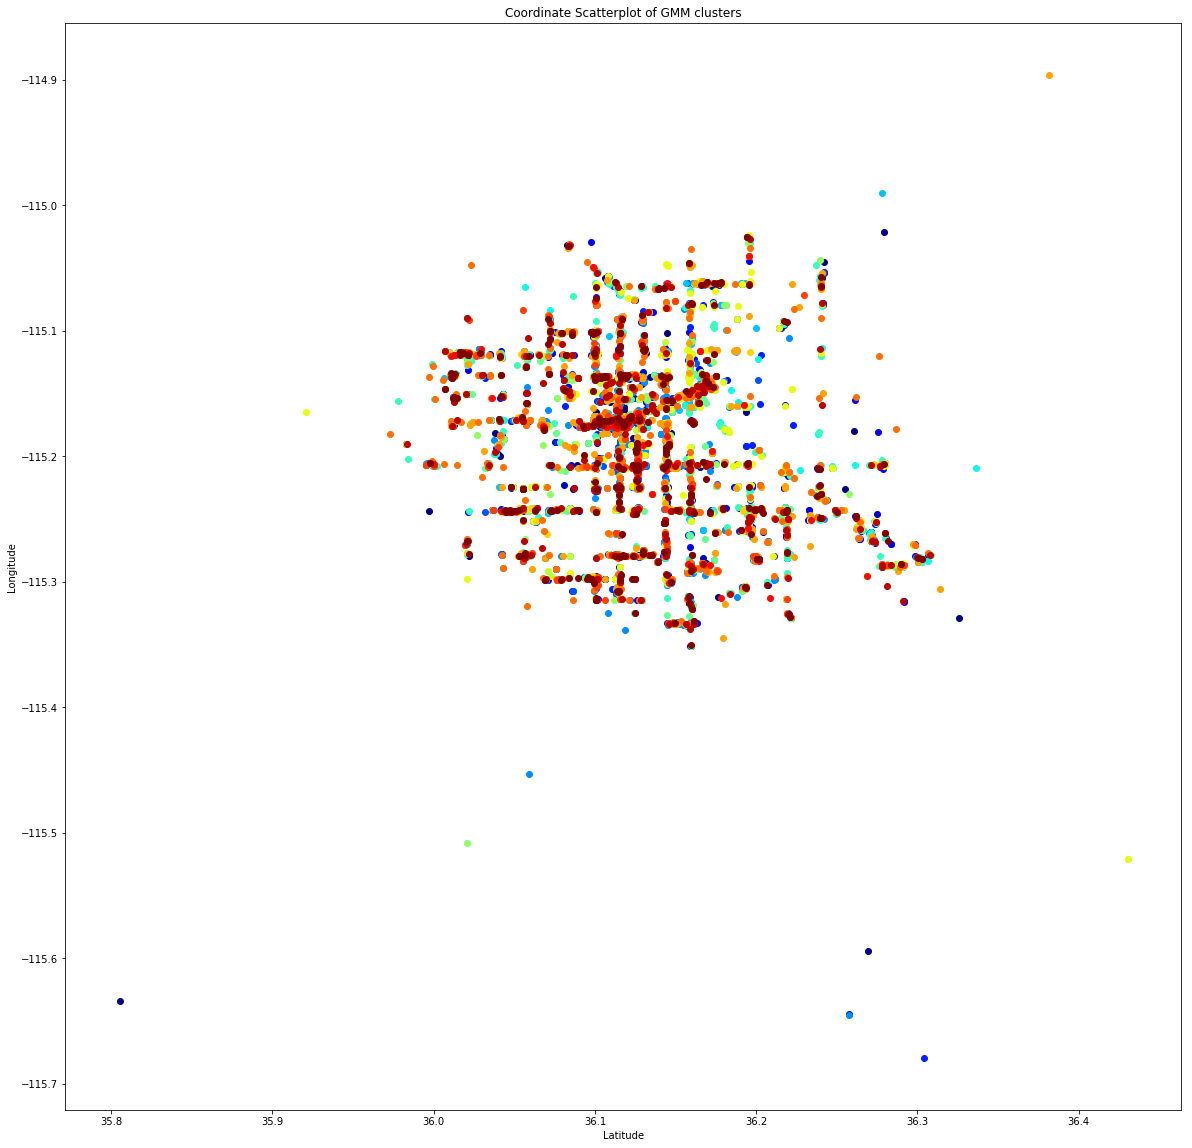

In [129]:
#Using the Silhouete Score 20 clusters is the best choice for clustering
K = 20

Gmm=mixture.GMM(n_components=K,covariance_type='spherical')
result_2 = Gmm.fit_predict(mat)

figure_plt=plt.figure(figsize=(20,20))
colors = matplotlib.cm.jet(np.linspace(0, 1, K))
inertia_g=0
s_g = silhouette_score(mat,result_2)
for k in range(K):
    kmean_gmm=KMeans(init='k-means++',n_clusters=1,max_iter=300)
    label_gmm = kmean_gmm.fit_predict(mat[result_2==k])
    inertia_g +=kmean_gmm.inertia_
    asc_centroids_g=kmean_gmm.cluster_centers_[:,-K:].argsort()[:,::-1][0]
    plt.scatter(latitudes[result_2==k],longitudes[result_2==k],c=colors[k,:]) 

plt.title('Coordinate Scatterplot of GMM clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [ ]:
for i in range(20):
        print("Cluster %d:" % i)
        for ind in asc_centroids_g[i,:10]:
            print(terms[ind+1])
        print("______________")

Compare your clusters with the results you obtained in Part 1. Use cluster comparison metrics, and also comment on which clustering appears (from your inspection of the clusters) to be more informative, and why. **(15 pts)**

In [1]:
print("Silhouette Scores")
print(s_k)
print(s_h)
print(s_g)

Silhouette Scores
0.194146143373
0.164492709058
0.17500499186


In [2]:
print("Sum of squared distances of samples closest to their cluster centers")
print(inertia_k)
print(inertia_h)
print(inertia_g)

Sum of squared distances of samples closest to their cluster centers
1799.77270075
1913.57971969
1826.79770458


Comparing the clusters using silhouette scores and in Sum of squared distances of samples to their closest cluster centers cluster.We can get better clustering if we use reviews for clustering. Kmeans performs better than both the other methods

This silhouette scores are pretty low. The clusters are clearly separated.

From processing reviews, we can get more informative descriptions for each cluster.

----------